### Buscar questões do dataset Chave

In [8]:
import manager_dataset as _md

questions = _md.pairs()

### Pré-processamento no texto das questões

In [9]:
import numpy as np
import random
import nltk

X = []
y = []
for question in questions:
    
    clss = question.correct_classification
    
    if clss == None:
        continue
    if clss == 'X':
        continue
    if clss == 'MANNER':
        continue
    if clss == 'OBJECT':
        continue
    if clss == 'OTHER':
        continue
    
    text = question.question
    text = text.replace('\n', '').replace('\r', '')
    text = text.replace('?', ' ? ').replace('.', ' . ').replace(',', ' , ')
    text = text.replace(':', ' : ').replace(';', ' ; ')
    text = text.replace('\'', ' \" ').replace('\"', ' \" ')
    text = text.replace(u'«', ' \" ').replace(u'»', ' \" ')
    text = text.lower()
    question.question = text
    
    text = nltk.word_tokenize(text)
    X.append(text)
    y.append(clss)

                
print 'X:',len(X),' y:',len(y)
random.seed(1)
a = zip(X, y)
random.shuffle(a)
X, y = zip(*a)
X, y = np.array(X), np.array(y)


X: 2973  y: 2973


### Modelo Word2Vec

In [1]:
import numpy as np
from gensim.models import KeyedVectors
import time

start_time = time.time()
print time.asctime()
cbow_w2v_300 = 'data/word_embedding/cbow_s300.txt'

mw2v_300 = KeyedVectors.load_word2vec_format(cbow_w2v_300, unicode_errors="ignore")
print '.'
w2v_300 = {w: vec for w, vec in zip(mw2v_300.index2word, mw2v_300.syn0)}

print("--- %s min ---" % (time.time() - start_time)/float(60))

Wed Oct  4 11:04:03 2017
.
--- 1142.875736 seconds ---


### Modelos de representação em vetor

In [69]:
import numpy as np
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


def count_vectorizer(MIN_GRAM=1, MAX_GRAM=1, LOWER=True):
    return CountVectorizer(analyzer=lambda x: x, strip_accents=None, ngram_range=(MIN_GRAM, MAX_GRAM), 
                           token_pattern=u'(?u)\\b\\w+\\b', lowercase=LOWER)


def tfidf_vectorizer(MIN_GRAM=1, MAX_GRAM=1, LOWER=True):
    return TfidfVectorizer(analyzer=lambda x: x, strip_accents=None, ngram_range=(MIN_GRAM, MAX_GRAM), 
                           token_pattern=u'(?u)\\b\\w+\\b', lowercase=LOWER)


class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(word2vec.itervalues().next())
    
    def fit(self, X, y):
        return self

    def transform(self, X):
        ret = np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
        return ret

class HybridVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(word2vec.itervalues().next())
        self.bow = count_vectorizer()
        
    
    def fit(self, X, y):
        self.bow.fit(X)
        return self

    def transform(self, X):
        ret = []
        for sentence in X:
            w2v = np.mean([self.word2vec[w] for w in sentence if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            bow = self.bow.transform([sentence]).toarray()
            ret.append(np.concatenate([w2v, bow[0]]))
        ret = np.array(ret)
        return ret

class TfidfHybridVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(word2vec.itervalues().next())
        self.tf = tfidf_vectorizer()
        
    
    def fit(self, X, y):
        self.tf.fit(X)
        return self

    def transform(self, X):
        ret = []
        for sentence in X:
            w2v = np.mean([self.word2vec[w] for w in sentence if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            tf = self.tf.transform([sentence]).toarray()
            ret.append(np.concatenate([w2v, tf[0]]))
        ret = np.array(ret)
        return ret

## Definir classificadores

In [70]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.ensemble import ExtraTreesClassifier


classifiers = {}  # {'classifier': (VectorizeModel, Classifier)}

#### SVM Linear

In [71]:
classifiers["BoW"] = (LinearSVC(), count_vectorizer())

In [72]:
classifiers["BoW tfidf"] = (LinearSVC(), tfidf_vectorizer())

In [73]:
classifiers["W2V"] = (LinearSVC(), MeanEmbeddingVectorizer(w2v_300))

In [74]:
classifiers["Hybrid"] = (LinearSVC(), HybridVectorizer(w2v_300))

In [75]:
classifiers["Hybrid tfidf"] = (LinearSVC(), TfidfHybridVectorizer(w2v_300))

#### Naive Bayes

In [17]:
classifiers["NB mult"] = (MultinomialNB(), count_vectorizer())

In [19]:
classifiers["NB mult tfidf"] = (MultinomialNB(), tfidf_vectorizer())

In [18]:
classifiers["NB bernoulli"] = (BernoulliNB(), count_vectorizer())

In [20]:
classifiers["NB bern tfidf"] = (BernoulliNB(), tfidf_vectorizer())

#### ExtraTrees

In [21]:
classifiers["ETree"] = (ExtraTreesClassifier(n_estimators=200), count_vectorizer())

In [22]:
classifiers["ETree tfidf"] = (ExtraTreesClassifier(n_estimators=200), tfidf_vectorizer())

In [23]:
classifiers["ETree W2V"] = (ExtraTreesClassifier(n_estimators=200), MeanEmbeddingVectorizer(w2v_300))

## Testes

In [102]:
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

def benchmark(model, X, y, n):
    test_size = 1 - (n / float(len(y)))
    scores = {}
    for train, test in StratifiedShuffleSplit(y, n_iter=5, test_size=test_size, random_state=0):
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]
        result = model.fit(X_train, y_train).predict(X_test)
        scores['accuracy'] = accuracy_score(result, y_test)
        scores['precision'] = precision_score(result, y_test, average="macro")
        scores['recall'] = recall_score(result, y_test, average="macro")
        scores['f1'] = f1_score(result, y_test, average="macro")
        scores['confusion'] = confusion_matrix(result, y_test)
    return scores

train_sizes = [80, 160, 240, 320, 400, 480, 560, 640, 720, 800, 880, 960, 1040, 1120, 1200, 1280, 1360, 
               1440, 1520, 1600, 1680, 1760, 1840, 1920, 2000, 2080, 2160, 2240, 2320, 2400, 2480]
table = []
for name in classifiers:
    print name,
    model = Pipeline([("vector_model", classifiers[name][1]), ("classifer", classifiers[name][0])])
    print '-',
    for n in train_sizes:
        result = benchmark(model, X, y, n)
        table.append({'model': name, 
                      'accuracy': np.mean(result['accuracy']),
                      'precision': np.mean(result['precision']),
                      'recall': np.mean(result['recall']),
                      'f1': np.mean(result['f1']),
                      #'confusion': np.mean(result['confusion'], axis=0),
                      'train_size': n})
        print n,
    print '.'


BoW tfidf - 80 160 240 320 400 480 560 640 720 800 880 960 1040 1120 1200 1280 1360 1440 1520 1600 1680 1760 1840 1920 2000 2080 2160 2240 2320 2400 2480 .
W2V - 80 160 240 320 400 480 560 640 720 800 880 960 1040 1120 1200 1280 1360 1440 1520 1600 1680 1760 1840 1920 2000 2080 2160 2240 2320 2400 2480 .
Hybrid tfidf - 80 160 240 320 400 480 560 640 720 800 880 960 1040 1120 1200 1280 1360 1440 1520 1600 1680 1760 1840 1920 2000 2080 2160 2240 2320 2400 2480 .
Hybrid - 80 160 240 320 400 480 560 640 720 800 880 960 1040 1120 1200 1280 1360 1440 1520 1600 1680 1760 1840 1920 2000 2080 2160 2240 2320 2400 2480 .
BoW - 80 160 240 320 400 480 560 640 720 800 880 960 1040 1120 1200 1280 1360 1440 1520 1600 1680 1760 1840 1920 2000 2080 2160 2240 2320 2400 2480 .


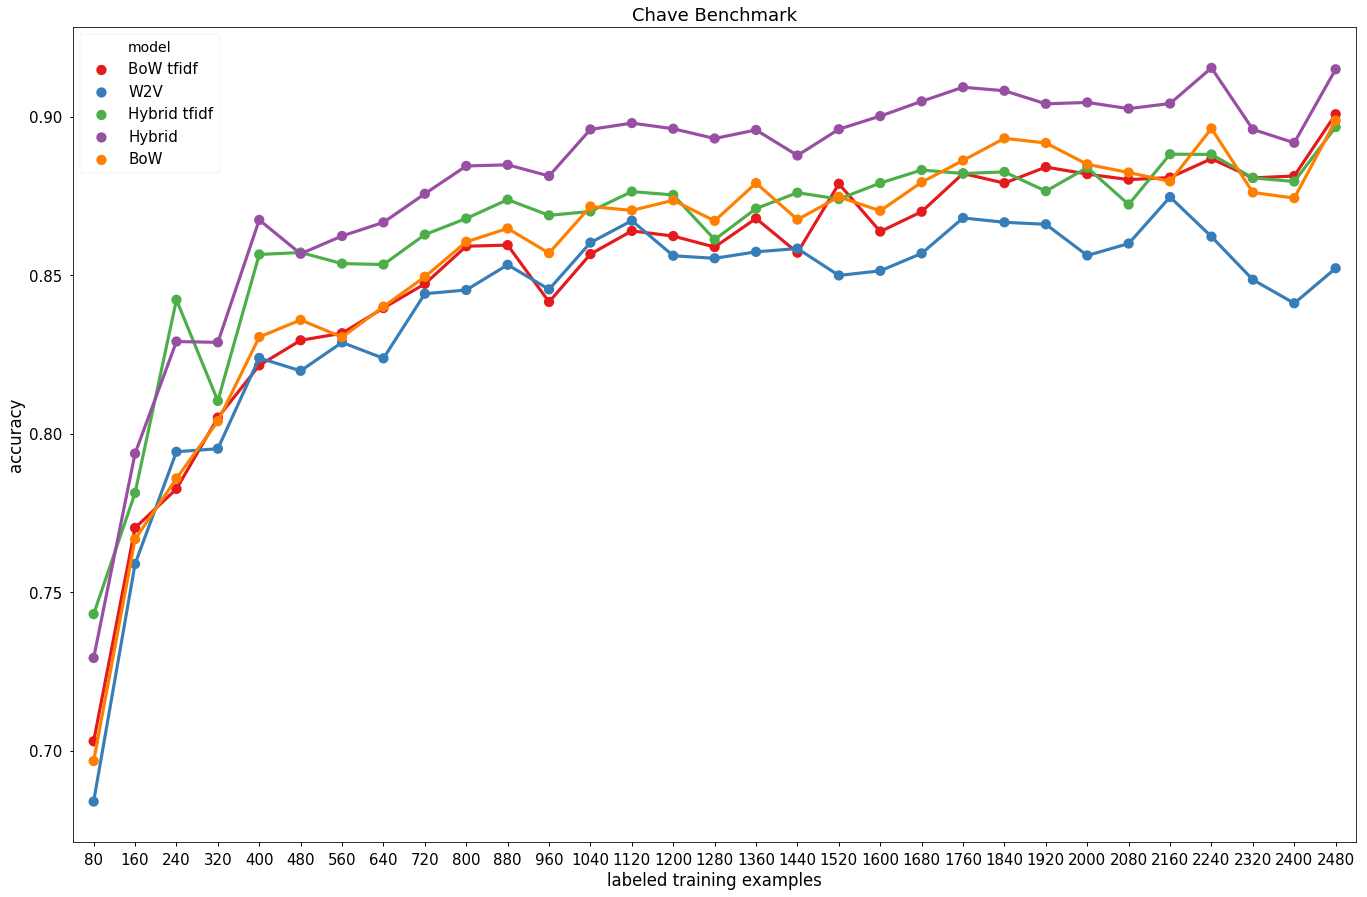

In [107]:
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

sns.set_palette(sns.color_palette("Set1", 5))

df = pd.DataFrame(table)
plt.figure(figsize=(23, 15))
names = ['BoW', 'BoW tfidf', 'W2V', 'Hybrid', 'Hybrid tfidf']
fig = sns.pointplot(x='train_size', y='accuracy', hue='model', 
                    data=df[df.model.map(lambda x: x in names)])
sns.set_context("notebook", font_scale=1.5)
fig.set(ylabel="accuracy")
fig.set(xlabel="labeled training examples")
fig.set(title="Chave Benchmark")
fig.set(ylabel="accuracy")

In [113]:
def print_scores(model):
    last = {}
    for t in table:
        if t['model'] == model:
            last['train_size'] = t['train_size']
            last['precision'] = t['precision']
            last['recall'] = t['recall']
            last['f1'] = t['f1']
            last['accuracy'] = t['accuracy']
    print 'Train Size: ', last['train_size']
    print 'Precision: ', round(last['precision'],4)
    print 'Recall: ', round(last['recall'],4)
    print 'F1: ', round(last['f1'],4)
    print 'Accuracy: ', round(last['accuracy'],4)

print '\n\nBoW:\n'
print_scores('BoW')
print '\n\nBoW tfidf:\n'
print_scores('BoW tfidf')
print '\n\nWord2Vec:\n'
print_scores('W2V')
print '\n\nHybrid:\n'
print_scores('Hybrid')
print '\n\nHybrid tfidf:\n'
print_scores('Hybrid tfidf')




BoW:

Train Size:  2480
Precision:  0.8951
Recall:  0.8945
F1:  0.8945
Accuracy:  0.8988


BoW tfidf:

Train Size:  2480
Precision:  0.8962
Recall:  0.9008
F1:  0.8978
Accuracy:  0.9008


Word2Vec:

Train Size:  2480
Precision:  0.8459
Recall:  0.8442
F1:  0.8442
Accuracy:  0.8522


Hybrid:

Train Size:  2480
Precision:  0.9115
Recall:  0.9081
F1:  0.9097
Accuracy:  0.915


Hybrid tfidf:

Train Size:  2480
Precision:  0.8978
Recall:  0.9035
F1:  0.8975
Accuracy:  0.8968


In [112]:
import scipy

a = []
b = []

for t in table:
    if t['model'] == 'Hybrid':
        a.append(t['accuracy'])
    if t['model'] == 'BoW tfidf':
        b.append(t['accuracy'])

scipy.stats.ttest_ind(a, b)

Ttest_indResult(statistic=2.7609110004411122, pvalue=0.0076359131271755819)